# Annotation Artifacts in Natural Language Inference Data

This notebook analyses annotations in the [SNLI](https://nlp.stanford.edu/projects/snli/) and [MultiNLI](https://www.nyu.edu/projects/bowman/multinli/) datasets, showing consistent patterns in the data which might cause models to achieve inflated performance.

If using in your research, please cite [our NAACL paper](https://aclweb.org/anthology/N18-2017)

```
@inproceedings{gururangan2018annotation,
  title={Annotation Artifacts in Natural Language Inference Data},
  author={Gururangan, Suchin and Swayamdipta, Swabha and Levy, Omer and Schwartz, Roy and Bowman, Samuel and Smith, Noah A},
  booktitle={Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 2 (Short Papers)},
  pages={107--112},
  year={2018}
}
```

## Installation

First, you would need to install some packages:

```
pip install matplotlib
pip install nltk
pip install numpy
pip install pandas
pip install re
pip install seaborn
pip install string
pip install tqdm
```

## Load dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string

from collections import Counter
from nltk import PorterStemmer
from IPython.core.debugger import Tracer
from tqdm import tqdm

#tqdm.pandas("mybar!")

%matplotlib inline

## Load Data

Here, we only show SNLI, but MNLI, being in the same format can be processed similarly.

In [2]:
%%capture

snli = pd.read_csv('/Users/swabhas/data/aflite/snli_1.0_glue/train.tsv',
                   sep = '\t',
                   error_bad_lines=False).dropna(subset=['sentence2',
                                                         'sentence2_binary_parse',
                                                         'sentence2_parse'])

## Functions

In [3]:
def tokenize(string):
    """
    tokenize string from binary parse
    """
    string = re.sub(r'\(|\)', '', str(string))
    return string.lower().split()

def plot_tokens(df):
    """
    plot token length dist
    """
    total_count = df.sentence2.apply(lambda x: len(x)).sum()
    ax = (df.sentence2_binary_parse
            .apply(lambda x: len(tokenize(x)))
            .value_counts()
            .sort_index()
            .div(total_count)
            .plot(kind='line', legend=True, ylim=[0 , 0.006]))
    return ax

def plot_characters(df):
    """
    plot character length dist
    """
    total_count = df.sentence2.apply(lambda x: len(x)).sum()
    ax = (df.sentence2
            .apply(lambda x: len(x))
            .value_counts()
            .sort_index()
            .div(total_count)
            .plot(kind='line', legend=True, ylim=[0 , 0.0012]))
    return ax

def ppmi(df):
    """
    computes positive pointwise mutual information between labels and words in the hypothesis.
    Args:
        df -> dataframe (mnli or snli)
    Returns:
        ppmis -> pmi data
    """
    alpha = 10.0  # for smoothing
    
    # get joint (w,c) counts
    Px = []
    Py = []
    Pxy = []
    for idx, row in df.iterrows():
        for word in tokenize(row.sentence2_binary_parse):
            Pxy.append((word, row.gold_label))
            Px.append(word)
        Py.append(row.gold_label)
    Pxy = Counter(Pxy)
    Px = Counter(Px)
    Py = Counter(Py)
    Py = {y: c + len(Px)*alpha for y, c in Py.items()}
    Px = {x: c + 3*alpha for x, c in Px.items()}
    total_word_count = sum(Px.values())

    # get c counts
    ppmis = []
    
    seen_pairs = {}
    total_Py = 3
    for word in Px.keys():
        for cls in ['contradiction', 'entailment', 'neutral']:
            if seen_pairs.get((word, cls)) is None:
                # artificial smoothing
                word_count = float(Px[word])
                cls_count = float(Py[cls])
                word_cls_count = Pxy.get((word, cls), 0.0) + alpha
                z = (float(word_cls_count) * total_word_count / (float(word_count) * float(cls_count)))
                # ppmi
                ppmi = max([np.log(z), 0.0])
                output = {'word': word,
                          'class': cls,
                          'ppmi': ppmi,
                          'count': word_count - 3*alpha,
                          'wc_count': Pxy.get((word, cls), 0.0),}
                seen_pairs[(word, cls)] = 1
                ppmis.append(output)
    return pd.DataFrame(ppmis)

## PPMI and Token Length Distributions


In [10]:
snli_ppmi = ppmi(snli)

#### Top 20 PPMIs across (class, word) pairs in SNLI

In [11]:
snli_ppmi.sort_values(by='ppmi', ascending=False).head(n=20)

,class,count,ppmi,wc_count,word
651,contradiction,2192.0,2.359585,2182.0,nobody
4377,contradiction,759.0,2.280274,709.0,cats
3191,neutral,339.0,2.267198,322.0,championship
5636,neutral,159.0,2.261011,159.0,joyously
4146,contradiction,534.0,2.260701,494.0,nothing
167,neutral,594.0,2.248444,541.0,vacation
4681,entailment,364.0,2.245740,337.0,least
81,contradiction,243.0,2.244346,230.0,frowning
1497,contradiction,949.0,2.242416,849.0,naked
347,neutral,640.0,2.235483,574.0,winning


### Graphs for PPMI

#### Top 20 words occuring with the class `contradiction`

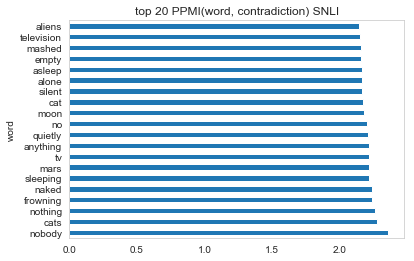

In [22]:
sns.set_style("whitegrid", {'axes.grid' : False})
ax = (snli_ppmi.loc[snli_ppmi['class'] == 'contradiction']
              .sort_values(by='ppmi', ascending=False)
              .head(n=20)
              .plot(kind='barh', x='word', y='ppmi', title='top 20 PPMI(word, contradiction) SNLI', legend=False))


#### Top 20 words occuring with the class `entailment`

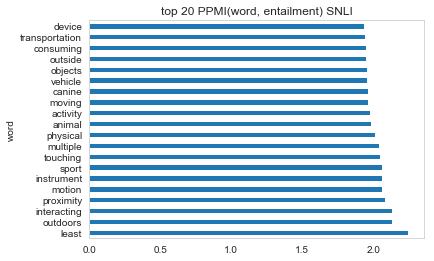

In [18]:
sns.set_style("whitegrid", {'axes.grid' : False})
ax = (snli_ppmi.loc[snli_ppmi['class'] == 'entailment']
              .sort_values(by='ppmi', ascending=False)
              .head(n=20)
              .plot(kind='barh', x='word', y='ppmi', title='top 20 PPMI(word, entailment) SNLI', legend=False))


#### Top 20 words occuring with the class `neutral`

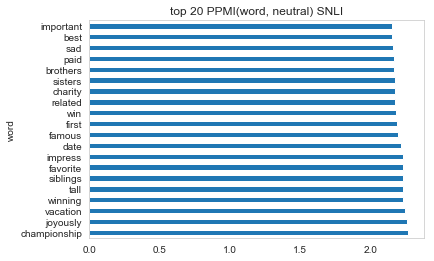

In [19]:
sns.set_style("whitegrid", {'axes.grid' : False})
ax = (snli_ppmi.loc[snli_ppmi['class'] == 'neutral']
              .sort_values(by='ppmi', ascending=False)
              .head(n=20)
              .plot(kind='barh', x='word', y='ppmi', title='top 20 PPMI(word, neutral) SNLI', legend=False))

## Token Length Distributions

In [20]:
contradiction_snli = snli.loc[snli.gold_label == 'contradiction']
entailment_snli = snli.loc[snli.gold_label == 'entailment']
neutral_snli = snli.loc[snli.gold_label == 'neutral']

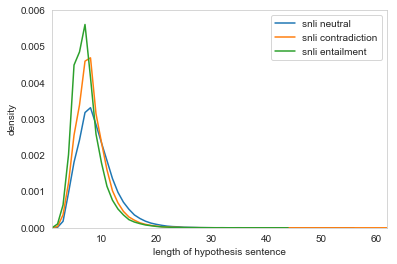

In [51]:
_ = plot_tokens(neutral_snli)
_ = plot_tokens(contradiction_snli)
ax = plot_tokens(entailment_snli)
ax.set_xlabel('length of hypothesis sentence')
ax.set_ylabel('density')
ax.legend(["snli neutral",
           "snli contradiction",
           "snli entailment"])
# ax.set_ylim([0, 0.0012])